# Supervised Learning - Refurbished Devices Pricing 
 
### Objective
The used device data will be analyzed and used to build a linear regression model to predict the price of a used phone/tablet and identify factors that significantly influence it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#for QQ plots:
import pylab
import scipy.stats as stats

#for Goldfeldquandt test: 
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

## Data Overview

In [2]:
data = pd.read_csv("used_device_data.csv")

In [3]:
df = data.copy()

## Exploratory Data Analysis

<b>Questions</b>:
1. What does the distribution of used device prices look like?
2. What percentage of the used device market is dominated by Android devices?
3. The amount of RAM is important for the smooth functioning of a device. How does the amount of RAM vary with the brand?
4. A large battery often increases a device's weight, making it feel uncomfortable in the hands. How does the weight vary for phones and tablets offering large batteries (more than 4500 mAh)?
5. Bigger screens are desirable for entertainment purposes as they offer a better viewing experience. How many phones and tablets are available across different brands with a screen size larger than 6 inches?
6. Budget devices nowadays offer great selfie cameras, allowing us to capture our favorite moments with loved ones. What is the distribution of budget devices offering greater than 8MP selfie cameras across brands?
7. Which attributes are highly correlated with the price of a used device?

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
screen_size,3454.0,13.713115,3.805280,5.08,12.7000,12.830,15.340,30.71
main_camera_mp,3275.0,9.460208,4.815461,0.08,5.0000,8.000,13.000,48.00
selfie_camera_mp,3452.0,6.554229,6.970372,0.00,2.0000,5.000,8.000,32.00
int_memory,3450.0,54.573099,84.972371,0.01,16.0000,32.000,64.000,1024.00
ram,3450.0,4.036122,1.365105,0.02,4.0000,4.000,4.000,12.00
battery,3448.0,3133.402697,1299.682844,500.00,2100.0000,3000.000,4000.000,9720.00
weight,3447.0,182.751871,88.413228,69.00,142.0000,160.000,185.000,855.00
release_year,3454.0,2015.965258,2.298455,2013.00,2014.0000,2015.500,2018.000,2020.00
days_used,3454.0,674.869716,248.580166,91.00,533.5000,690.500,868.750,1094.00
new_price,3454.0,237.038848,194.302782,18.20,120.3425,189.785,291.115,2560.20


Observations: 
- This table contains the 5-point summary statistics for each numerical column within the dataset (integer and float types). This gives us the total count of values, the mean (average), standard deviation, the smallest value (min), the 1st/2nd/3rd quantile values, and the largest values (max). 
- We cannot calculate the summary statistics for columns with non-numerical data such as brand_name, os, 4g, 5g, and release_year. 

In [5]:
#converting appropriate object type columns to category types to make the generation of dummy variables easier later
categorical_variables = ["os", "4g", "5g"]

for colname in categorical_variables:
    df[colname] = df[colname].astype("category")
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   brand_name        3454 non-null   object  
 1   os                3454 non-null   category
 2   screen_size       3454 non-null   float64 
 3   4g                3454 non-null   category
 4   5g                3454 non-null   category
 5   main_camera_mp    3275 non-null   float64 
 6   selfie_camera_mp  3452 non-null   float64 
 7   int_memory        3450 non-null   float64 
 8   ram               3450 non-null   float64 
 9   battery           3448 non-null   float64 
 10  weight            3447 non-null   float64 
 11  release_year      3454 non-null   int64   
 12  days_used         3454 non-null   int64   
 13  new_price         3454 non-null   float64 
 14  used_price        3454 non-null   float64 
dtypes: category(3), float64(9), int64(2), object(1)
memory usage: 334.5+ KB


In [6]:
#log transforming used_price to make the distribution more normal
df['used_price_log'] = np.log(df['used_price'])
df['new_price_log'] = np.log(df['new_price'])

### Bivariate Analysis
#### Correlations

In [7]:
df[df.columns[:]].corr()["used_price"][:]

screen_size         0.529275
main_camera_mp      0.459209
selfie_camera_mp    0.614675
int_memory          0.378347
ram                 0.529434
battery             0.549647
weight              0.357983
release_year        0.494910
days_used          -0.385777
new_price           0.809335
used_price          1.000000
used_price_log      0.894738
new_price_log       0.775425
Name: used_price, dtype: float64

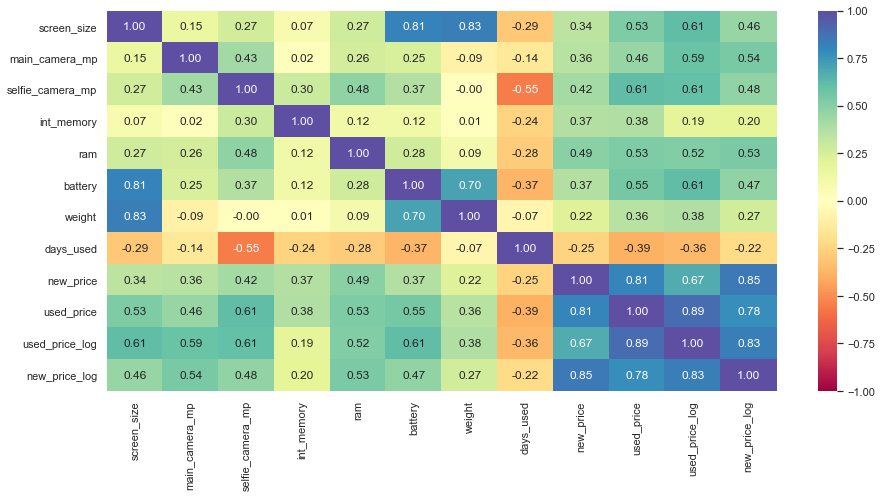

In [8]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
numeric_columns.remove("release_year") #dropping year column because it is a temporal variable

#correlation heatmap
plt.figure(figsize=(15,7))
sns.heatmap(
    df[numeric_columns].corr(),
    annot = True, 
    vmin = -1, 
    vmax = 1,
    fmt = ".2f",
    cmap = "Spectral")
plt.show()

Observations: 
- battery and weight are particularly interesting. These are highly correlated with screen_size indicating that these may be traits that go together on many devices. These variables may be able to be grouped together for valuable insights. 
- Compared to our dependent variable (used_price), battery, screen_size, ram, selfie_camera_mp, and screen_size are the highest correlated. 

#### Boxplots and barplots

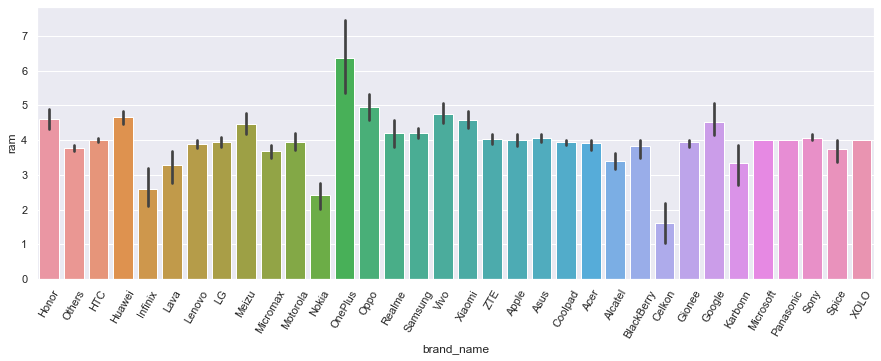

In [9]:
#brand_name vs ram
plt.figure(figsize=(15, 5))
sns.barplot(data=df, x="brand_name", y="ram")
plt.xticks(rotation=60)
plt.show()

<b>3. The amount of RAM is important for the smooth functioning of a device. How does the amount of RAM vary with the brand? </b>

Observations: 
- The amount of RAM overall varies widely between brands. 
- OnePlus has the most RAM compared to any other brand available with a mean of approximately 6.3 GB. 
- Celkon has the least RAM compared to the other brands with a mean of approximately 1.5 GB. 
- Most brands seem to have a mean of about 2.5-5 GB of RAM overall. 

<b>6. Budget devices nowadays offer great selfie cameras, allowing us to capture our favorite moments with loved ones. What is the distribution of budget devices offering greater than 8MP selfie cameras across brands? </b>

In [10]:
#creating a "good front camera" group

good_selfie_cam = df[df.selfie_camera_mp > 8]
good_selfie_cam.shape

(655, 17)

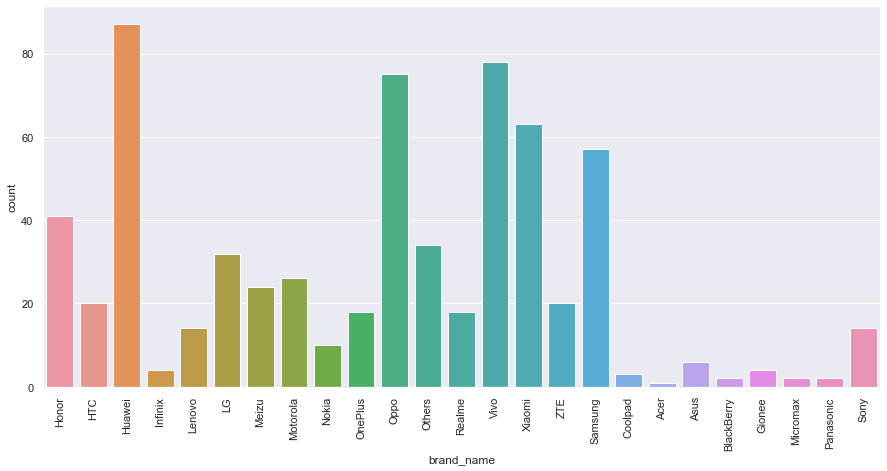

In [11]:
#comparing the devices with good selfie cameras by brand
#using a countplot

plt.figure(figsize=(15,7))
sns.countplot(x= "brand_name", data=good_selfie_cam)
plt.xticks(rotation = 90) #rotates the x-axis labels by 60 degrees
plt.show()

- It appears that the devices in our dataset that have good selfie cameras are not fully dominated by 1 brand.
- Many brands offer good selfie cameras nowadays. So if a customer is looking for a device with a good selfie camera, they do not need to limit their search to one specific brand in order to find one. 

However, this does not give us much of an idea of the prices of the devices with good selfie camera by brand. To get a better idea of this, we can separate all of our devices in our df dataframe into price categories. Then we can make another histogram of brands with good selfie cameras and use our price categories as a hue. 

In [12]:
#splitting devices into categories by price: budget, mid-range, premium using the new_price column 
#we will not be using the used_price column because other factors are likely to influence this value. 
#the new_price gives us a better idea of a "budget" phone vs a "premium" phone when it was originally sold. 

#using np.inf for numpy's infinity value and pd.cut to give benchmarks of where to group the data
df["device_category"] = pd.cut(df['new_price'], 
    [-np.inf, 200, 350, np.inf], 
    labels = ["Budget", "Mid-Range", "Premium"])
#groups the devices into categories of less than 200, 200-350, and more than 350 

print(df["device_category"].value_counts())
df.head()

Budget       1844
Mid-Range    1025
Premium       585
Name: device_category, dtype: int64


,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price,used_price,used_price_log,new_price_log,device_category
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,111.62,74.26,4.307572,4.715100,Budget
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,249.39,174.53,5.162097,5.519018,Mid-Range
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,359.47,165.85,5.111084,5.884631,Premium
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,278.93,169.93,5.135387,5.630961,Mid-Range
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,140.87,80.64,4.389995,4.947837,Budget


- All of the devices have been separated into the 3 categories. 
- These value counts contain all of the devices in the df dataframe. There are now 1844 devices in the "Budget" category, 1025 devices in the "Mid-Range" category, and 585 devices in the "Premium" category. 
-  We will now make another dataframe of good selfie camera phones so that the dataframe can contain the device_category column. 

In [13]:
#creating another "good front camera" group with the extra column

good_selfie_cam2 = df[df.selfie_camera_mp > 8]
print(good_selfie_cam2.shape)
good_selfie_cam2.head()

(655, 18)


,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price,used_price,used_price_log,new_price_log,device_category
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,249.39,174.53,5.162097,5.519018,Mid-Range
8,Honor,Android,15.32,yes,no,13.0,16.0,128.0,6.0,4000.0,165.0,2020,161,200.32,132.43,4.886054,5.299916,Mid-Range
12,Honor,Android,16.69,yes,yes,13.0,16.0,128.0,8.0,4100.0,206.0,2019,537,499.68,217.73,5.383256,6.213968,Premium
13,Honor,Android,15.32,yes,no,13.0,16.0,64.0,4.0,4000.0,171.5,2019,336,221.13,101.25,4.617593,5.398751,Mid-Range
16,Honor,Android,15.90,yes,no,13.0,32.0,128.0,6.0,3750.0,172.0,2019,395,249.12,151.77,5.022366,5.517935,Mid-Range


- device_category is now part of the good_selfie_cam2 dataframe. Now we can visualize this data. 

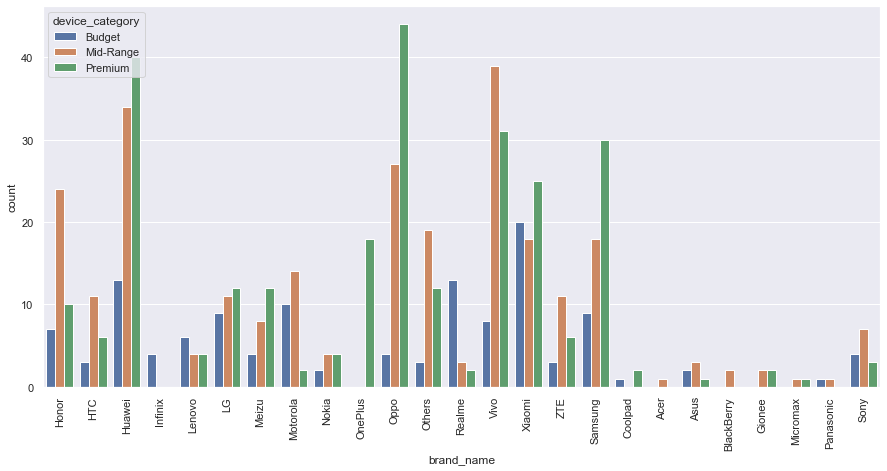

In [14]:
#comparing the devices with good selfie cameras by brand AND device_category
#using a countplot with a hue

plt.figure(figsize=(15,7))
sns.countplot(x= "brand_name", hue="device_category", data=good_selfie_cam2)
plt.xticks(rotation = 90) #rotates the x-axis labels by 60 degrees
plt.show()

- This gives us a better idea of the brands with good selfie cameras but separated by the device category. 
- For example: there are about 20 devices from the brand Xiaomi that have good selfie cameras AND are under 200 euros. 
- Another example: there are several devices (over 45) from the brand Oppo that have good selfie cameras but these are all premium devices and cost most than 350 euros. 
- This graph provides valuable info for customers that may want a device with a good selfie camera but want to stick to a specific budget. 

We can also repeat this same analysis with the back camera using the same methods. Front cameras tend to be much smaller than back/main cameras so the results may provide us with different information. 

In [15]:
#creating a "good back camera" group with the device_category column
#the overall mean and maximum values for the main camera megapixels in the original dataset is higher
#so we can consider a "good front camera" to be a camera with 16 megapixels instead of 8. 

good_front_cam = df[df.main_camera_mp > 8]
print(good_front_cam.shape)
good_front_cam.head()

(1560, 18)


,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price,used_price,used_price_log,new_price_log,device_category
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,111.62,74.26,4.307572,4.715100,Budget
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,249.39,174.53,5.162097,5.519018,Mid-Range
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,359.47,165.85,5.111084,5.884631,Premium
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,278.93,169.93,5.135387,5.630961,Mid-Range
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,140.87,80.64,4.389995,4.947837,Budget


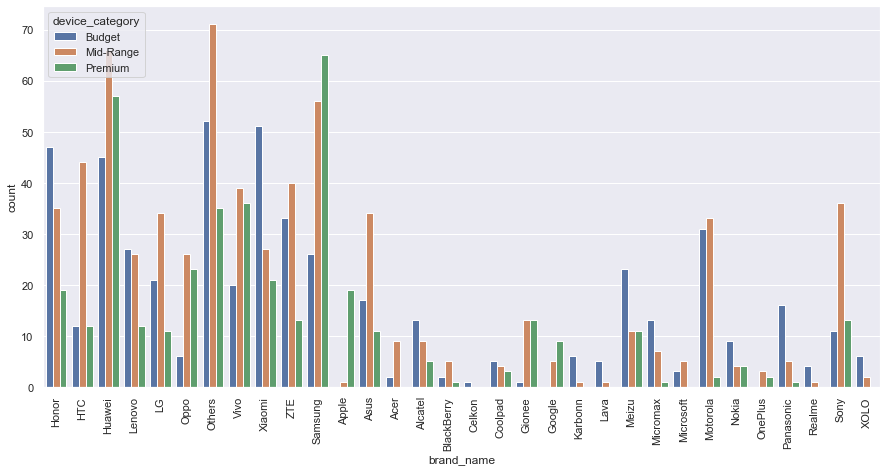

In [16]:
#comparing the devices with good main cameras by brand AND device_category
#using a countplot with a hue

plt.figure(figsize=(15,7))
sns.countplot(x= "brand_name", hue="device_category", data=good_front_cam)
plt.xticks(rotation = 90) #rotates the x-axis labels by 60 degrees
plt.show()

- If a customer wants a really good main camera instead of a good selfie camera (for photos of other people,  landscapes, etc.), the customer should be looking at different brands compared to the selfie camera analysis. 
- The brand Xiaomi still contains the most devices with good main cameras that are in the budget category (cost under 200 euros). 
- The brand Huawei contains many devices that are in a mid-range budget that have good main cameras. 
- Finally, Samsung has many devices with really good main cameras that are housed within a premium priced phone. 
    - Based on these graphs, Samsung offers really great main cameras but these phones may not also have a good selfie camera in it as well. 

<b>7. Which attributes are highly correlated with the price of a used device? </b>

Observations: 
- Based on the heat map above, battery, screensize, ram, selfie_camera_mp, and screen_size are the highest correlation values with used_price compared to the other attributes. 
    - selfie_camera_mp has the highest correlation with a value of 0.61
- new_price also has a high correlation value with used_price but these two variables seem like they would be very highly correlated anyways when you think about this logically. 

##### Used_price over time

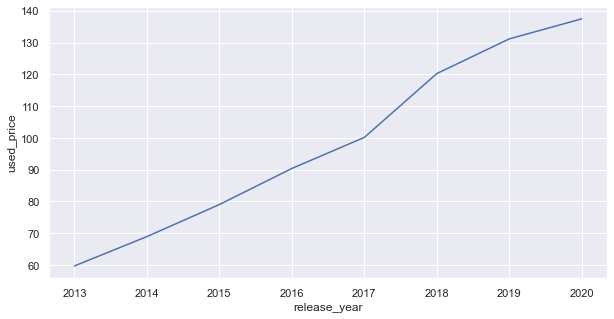

In [17]:
#used_price vs release_year
plt.figure(figsize=(10,5))
sns.lineplot(x="release_year", y="used_price", data=df, ci=None)
plt.show()

- Older phones are less expensive to buy used compared to newer phones.
- As the release year increases (and phones are newer), the price when used is more expensive.
- The price of used phones is increasing overall by year.

##### 4g and 5g availability by device_category

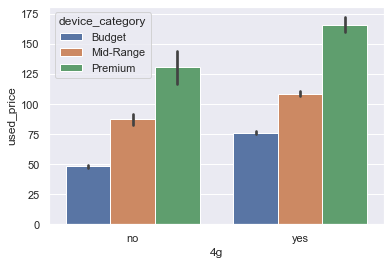

In [18]:
sns.barplot(data=df, x="4g", y="used_price", hue="device_category")
plt.show()

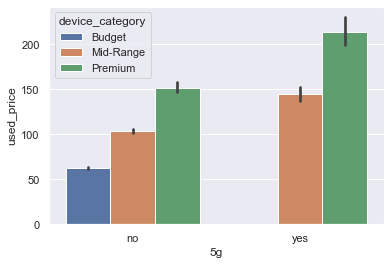

In [19]:
sns.barplot(data=df, x="5g", y="used_price", hue="device_category")
plt.show()

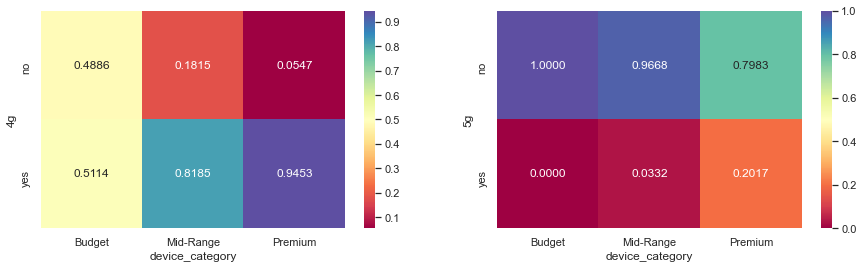

In [20]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
sns.heatmap(
    pd.crosstab(df["4g"], df["device_category"], normalize="columns"),
    annot=True,
    fmt=".4f",
    cmap="Spectral")

plt.subplot(122)
sns.heatmap(pd.crosstab(df["5g"], df["device_category"], normalize="columns"),
    annot=True,
    fmt=".4f",
    cmap="Spectral")

plt.show()

Overall, with the 2 barplots and the 2 heatmaps, we can draw a few observations:

4g: 
- There are not very many premium devices that do not have 4g capabilities. Therefore, if a customer has a premium budget, they are more than likely going to be able to get a device that at least has 4g capabilities. 
- There are many devices in the mid-range category that also have 4g capabilities. Not all of the devices in this category do, but many of them have 4g. 
- In the budget device category, approximately 50% of the devices are 4g compatible wile about 50% are not. 

5g: 
- There are no devices that are in the budget category (cost under 200 euros) that have 5g capabilities. 
- There are very few devices with 5g capability in the mid-range category. 
- About 80% of the premium devices are 5g capable while 20% are not. 
- Almost all of the devices of the entire dataset, the ones that have 5g capabilities typically cost over 350 euros. 

## Data Preprocessing

### Missing Value Treatment

In [21]:
#creating another copy of the data
df1 = df.copy()

In [22]:
#filling in the missing values from the columns: 
    #main_camera_mp, selfie_camera_mp, int_memory, ram, battery, and weight 
#using the column medians grouped by brand_name

cols_with_missings = [
    "main_camera_mp",
    "selfie_camera_mp",
    "int_memory",
    "ram",
    "battery",
    "weight"]

for col in cols_with_missings:
    df1[col] = df1.groupby('brand_name')[col].transform(lambda x: x.fillna(x.median()))

In [23]:
#main_camera_mp by column median

for col in cols_with_missings:
    df1["main_camera_mp"] = df1["main_camera_mp"].fillna(df1["main_camera_mp"].median()) 
    
#to check if it worked:
df1.isnull().sum()

brand_name          0
os                  0
screen_size         0
4g                  0
5g                  0
main_camera_mp      0
selfie_camera_mp    0
int_memory          0
ram                 0
battery             0
weight              0
release_year        0
days_used           0
new_price           0
used_price          0
used_price_log      0
new_price_log       0
device_category     0
dtype: int64

### Outlier Detection and Treatment

In [24]:
numerical_columns = df1.select_dtypes(include=np.number).columns.tolist()
# dropping release_year as it is a temporal variable
numerical_columns.remove("release_year")
print(numerical_columns)

['screen_size', 'main_camera_mp', 'selfie_camera_mp', 'int_memory', 'ram', 'battery', 'weight', 'days_used', 'new_price', 'used_price', 'used_price_log', 'new_price_log']


In [25]:
#creating a whole new dataframe with just the numerical variables
numerical_columns_df = df1.copy()
numerical_columns_df = numerical_columns_df.select_dtypes(include=np.number)
# dropping release_year as it is a temporal variable
#numerical_columns_df.drop("release_year")
numerical_columns_df.head()

,screen_size,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price,used_price,used_price_log,new_price_log
0,14.50,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,111.62,74.26,4.307572,4.715100
1,17.30,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,249.39,174.53,5.162097,5.519018
2,16.69,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,359.47,165.85,5.111084,5.884631
3,25.50,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,278.93,169.93,5.135387,5.630961
4,15.32,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,140.87,80.64,4.389995,4.947837


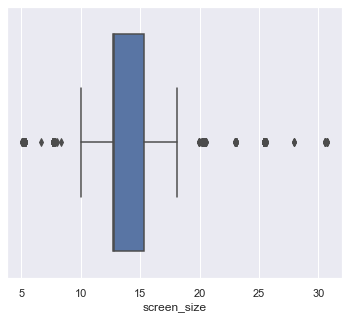

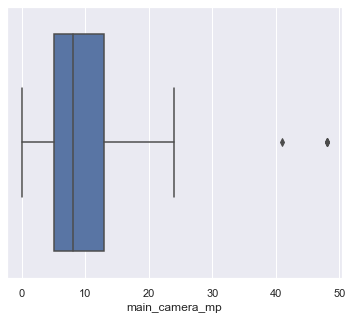

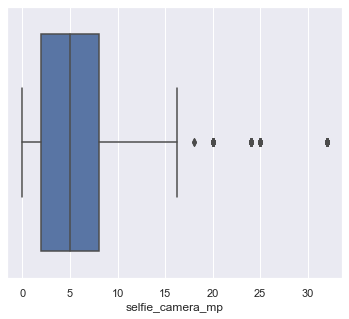

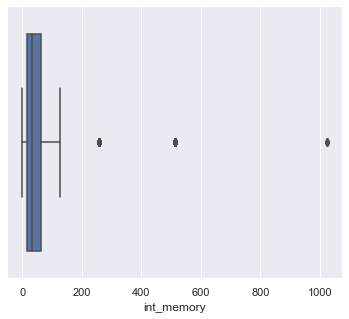

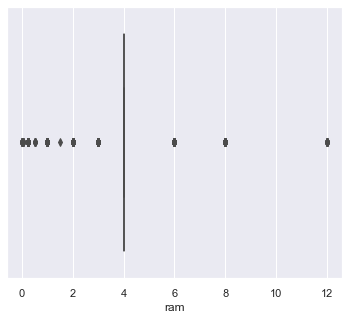

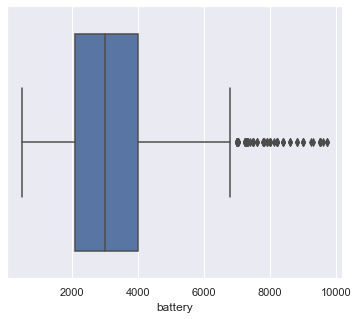

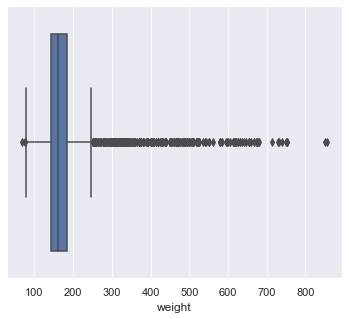

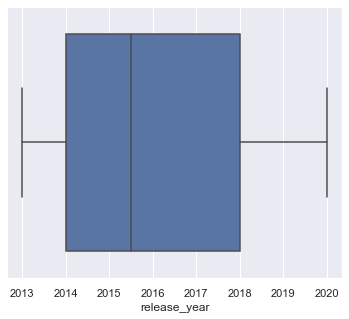

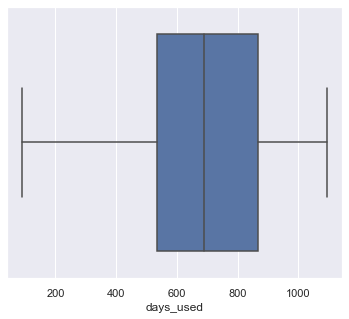

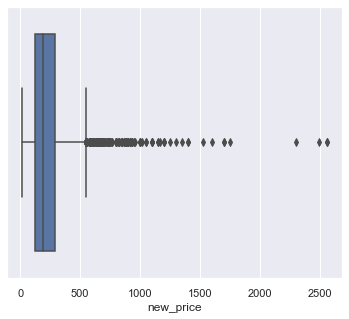

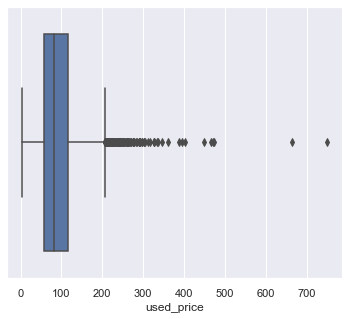

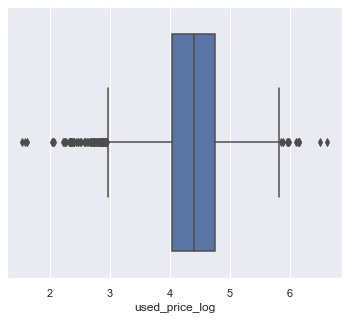

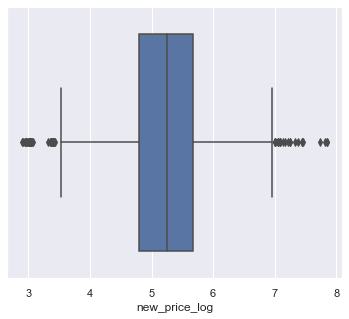

In [26]:
for column in numerical_columns_df:
    plt.figure(figsize=(6,5))
    sns.boxplot(data=numerical_columns_df, x=column)

- Many of the numerical columns have multiple outliers. 
- Most of these columns are independent variables and have ordinal, discrete values. So, even though many values are detected as outliers, we can use them as is and not fix them in any way. 
- The outliers that we really need to analyze are those of the "used_price_log" and "new_price_log" variables. 
    - Most of these outliers from these variables are flagged by the boxplot. But within the histograms for these variables (produced earlier), we can see that these outliers really are not inconsisent with the overall distribution of the data and the data is normally distributed. 
- All of the outliers from the numerical variables do not seem to be problematic overall. Therefore, they will not be treated or dropped. We will just stick to the original transformed variables. 

### Data Preparation for Modeling

#### Encoding categorical variables
- deciding which variables will need dummy variables

In [27]:
categorical_columns = df1.select_dtypes(include=["category", "object"]).columns.tolist()
print("The following columns will need to be converted to dummy variables:", categorical_columns)

The following columns will need to be converted to dummy variables: ['brand_name', 'os', '4g', '5g', 'device_category']


#### Defining the dependent and independent variables

In [28]:
X = df1.drop(['used_price', 'used_price_log', 'new_price', 'device_category'], axis=1)
y = df1['used_price_log']

print(X.head())
print(" ")
print(y.head())

  brand_name       os  screen_size   4g   5g  main_camera_mp  \
0      Honor  Android        14.50  yes   no            13.0   
1      Honor  Android        17.30  yes  yes            13.0   
2      Honor  Android        16.69  yes  yes            13.0   
3      Honor  Android        25.50  yes  yes            13.0   
4      Honor  Android        15.32  yes   no            13.0   

   selfie_camera_mp  int_memory  ram  battery  weight  release_year  \
0               5.0        64.0  3.0   3020.0   146.0          2020   
1              16.0       128.0  8.0   4300.0   213.0          2020   
2               8.0       128.0  8.0   4200.0   213.0          2020   
3               8.0        64.0  6.0   7250.0   480.0          2020   
4               8.0        64.0  3.0   5000.0   185.0          2020   

   days_used  new_price_log  
0        127       4.715100  
1        325       5.519018  
2        162       5.884631  
3        345       5.630961  
4        293       4.947837  
 
0    4

In [29]:
X = pd.get_dummies(
    X, 
    columns = X.select_dtypes(include=["object", "category"]).columns.tolist(),
    drop_first = True)

print(X.shape)
X.head()

(3454, 48)


,screen_size,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,new_price_log,brand_name_Alcatel,brand_name_Apple,brand_name_Asus,brand_name_BlackBerry,brand_name_Celkon,brand_name_Coolpad,brand_name_Gionee,brand_name_Google,brand_name_HTC,brand_name_Honor,brand_name_Huawei,brand_name_Infinix,brand_name_Karbonn,brand_name_LG,brand_name_Lava,brand_name_Lenovo,brand_name_Meizu,brand_name_Micromax,brand_name_Microsoft,brand_name_Motorola,brand_name_Nokia,brand_name_OnePlus,brand_name_Oppo,brand_name_Others,brand_name_Panasonic,brand_name_Realme,brand_name_Samsung,brand_name_Sony,brand_name_Spice,brand_name_Vivo,brand_name_XOLO,brand_name_Xiaomi,brand_name_ZTE,os_Others,os_Windows,os_iOS,4g_yes,5g_yes
0,14.50,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.715100,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,17.30,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.519018,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,16.69,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.884631,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,25.50,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.630961,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,15.32,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.947837,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


#### Splitting the data into train and test data

In [30]:
# Splitting the data into 70:30 ratio for train and test data

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [31]:
print("Number of rows in train data: ", x_train.shape[0])
print("Number of rows in test data:", x_test.shape[0])

Number of rows in train data:  2417
Number of rows in test data: 1037


## Linear Regression Model

### Building the Model

In [32]:
# adding constant to the train data
x_train1 = sm.add_constant(x_train)

# adding constant to the test data
x_test1 = sm.add_constant(x_test)

olsmodel1 = sm.OLS(y_train, x_train1).fit()
print(olsmodel1.summary())

                            OLS Regression Results                            
Dep. Variable:         used_price_log   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     268.8
Date:                Tue, 06 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:02:06   Log-Likelihood:                 124.15
No. Observations:                2417   AIC:                            -150.3
Df Residuals:                    2368   BIC:                             133.4
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -46.46

Observations: 
- Adjusted R-squared value = 0.842
    - This value reflects the current fit of our model. 0.842 is close to 1 which indicates that our model is generally a good fit. 
- our *const* Coefficient value is -46.4646. This represents our y-intercept. 

## Model Performance Evaluation
- In order to give us the best insights, we will transform the used and new price variables that are currently in log form using the .exp transformation to obtain the actual form. 
    - Logarithmic functions are the inverses of exponential functions. 
- Once, they are transformed, we will check the performance of the model again. 
- We will also be calculating and checking: RMSE, MAE, and MAPE for our model. 
    - RMSE = root mean square deviation
    - MAE = mean absolute error
    - MAPE = mean absolute percentage error

In [33]:
# Function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions)/targets) * 100

# Function to compute adjusted R-squared:
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1-r2) * (n-1) / (n-k-1))

# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    pred = model.predict(predictors) #predicting using the independent variables
    
    #computing the prices using .exp (exponential function)
    target = np.exp(target)
    pred = np.exp(pred)
    
    r2 = r2_score(target, pred) #to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred) #to compute adjusted R-squared
   
    rmse = np.sqrt(mean_squared_error(target, pred)) #to compute RMSE
    mae = mean_absolute_error(target,pred) #to compute MAE
    mape = mape_score(target, pred) #to compute MAPE
    
    #creating a dataframe of the metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse, 
            "MAE": mae, 
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape
        }, index = [0]
        )
    
    return df_perf

In [34]:
# Checking the model performance on the train set (70% of the data)
print ("Training Performance\n")
olsmodel1_train_perf = model_performance_regression(olsmodel1, x_train1, y_train)
olsmodel1_train_perf

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,25.123521,16.537847,0.794845,0.790598,18.869237


In [35]:
# Checking the model performance on the test set (30% of the data)
print ("Test Performance\n")
olsmodel1_test_perf = model_performance_regression(olsmodel1, x_test1, y_test)
olsmodel1_test_perf

Test Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,24.259754,16.602146,0.789237,0.778774,19.464147


Observations: 
- The train and test RMSE and MAE are super close in value and are very comparable. This indicates that our model is not overfitting. 
- The MAE suggests that the model can predict the used price within a mean error of 16.6 euros on the test data. 
- The MAPE of 19.46 on the test data means that we are able to predict the used price within 19.46%. 

## Checking Linear Regression Assumptions

The following linear regression assumptions will be checked:
1. No multicollinearity
2. Linearity of variables
3. Independence of error terms
4. Normality of error terms
5. No heteroscedasticity

### 1. Testing for Multicollinearity
Using VIF (Variance inflation factor)

In [36]:
#defining a function to check the VIF
def checking_vif(predictors):
    vif = pd.DataFrame()
    vif["feature"] = predictors.columns
    
    #calculating VIF for each feature
    vif["VIF"] = [variance_inflation_factor(predictors.values, i)
                 for i in range(len(predictors.columns))]
    return vif

In [37]:
#checking the VIF on the training data
checking_vif(x_train1)

,feature,VIF
0,const,3.791082e+06
1,screen_size,7.677118e+00
2,main_camera_mp,2.284685e+00
3,selfie_camera_mp,2.810716e+00
4,int_memory,1.364057e+00
5,ram,2.255246e+00
6,battery,4.081715e+00
7,weight,6.397183e+00
8,release_year,4.898360e+00
9,days_used,2.660002e+00


- screen_size, weight, brand_name_Huawei,brand_name_Others, and brand_name_Samsung have VIFs that are greater than 5.
- None of these VIFs are over 10 which indicates that the regression coefficients are not poorly estimated due to multicollinearity. So none of the variables will be dropped here. 
    - No true multicollinearity is present and assumption is satisfied. 

#### Checking p-values of the predictor variables to check their significance. 
- we will be checking all of the variables that have p-values > 0.05. 
- Because p-values sometimes change after dropping a variable, we will not be dropping all of the variables with high p-values all at once.
- We will approach this by building a model, checking the p-values of the variables, dropping the column with the highest p-value, creating a new model without that variable, checking the p-values again, dropping the column with the highest p-value, and then repeating until there are no more columns with p-values > 0.05. 
- We will be doing this using a while loop. 

In [38]:
print(olsmodel1.summary())

                            OLS Regression Results                            
Dep. Variable:         used_price_log   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     268.8
Date:                Tue, 06 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:02:06   Log-Likelihood:                 124.15
No. Observations:                2417   AIC:                            -150.3
Df Residuals:                    2368   BIC:                             133.4
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -46.46

- variables with high p-values: days_used, all of the brand_name_[X]s, os_Others, and os_iOS. 

In [39]:
#initial list of columns
cols = x_train1.columns.tolist()

#setting an initial max p-value
max_p_value = 1

while len(cols) > 0:
    #defining the train set
    x_train_aux = x_train1[cols]
    
    #fitting the model
    model = sm.OLS(y_train, x_train_aux).fit()
    
    #getting the p-values and the maximum p-value
    p_values = model.pvalues
    max_p_value = max(p_values)
    
    #name of the variable with maximum p-value
    feature_with_p_max = p_values.idxmax()
    
    if max_p_value > 0.05:
        cols.remove(feature_with_p_max)
    else: 
        break
        
selected_features = cols
print(selected_features)

['const', 'screen_size', 'main_camera_mp', 'selfie_camera_mp', 'ram', 'battery', 'weight', 'release_year', 'new_price_log', 'brand_name_Lenovo', 'brand_name_Nokia', 'brand_name_Xiaomi', 'os_Others', '4g_yes']


In [40]:
x_train2 = x_train1[["const"] + selected_features]
x_test2 = x_test1[["const"] + selected_features]

In [41]:
olsmod2 = sm.OLS(y_train, x_train2).fit()
print(olsmod2.summary())

                            OLS Regression Results                            
Dep. Variable:         used_price_log   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     988.3
Date:                Tue, 06 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:02:06   Log-Likelihood:                 104.95
No. Observations:                2417   AIC:                            -181.9
Df Residuals:                    2403   BIC:                            -100.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -19.4495      3.64

- After the function dropped some of the variables, none of the features have a p-value of greater than 0.05 anymore. 
- We will now consider x_train2 as the final set of predictor variables and olsmod2 as the final model for now. 

As of right now:
- the adj. R squared value is 0.842. Therefore, our model is able to explain ~84% of the variance. 
- Our original adj R squared value in olsmodel1 where all of the variables were considered, was also 0.842. This shows that the variables we dropped were not affecting the model much overall.  

### 2. Testing for Linearity and 3. Testing for Independence of Error Terms
Using olsmod2

- To test for linearity and independence, we will make a plot of the fitted values vs residuals. If no pattern is found within that scatter plot, we can say that the model is linear and the residuals are indpendent. 
- If the models shows signs of non-linearity and the residuals are not independent, we can try transforming the variables to make the relationships linear. 

In [42]:
#creating a dataframe with actual, fitted residual values
df_pred = pd.DataFrame()

df_pred["Actual Values"] = y_train #actual values
df_pred["Fitted Values"] = olsmod2.fittedvalues #predicted values
df_pred["Residuals"] = olsmod2.resid #residuals

df_pred.head()

,Actual Values,Fitted Values,Residuals
3026,4.087488,3.855295,0.232193
1525,4.448399,4.628844,-0.180445
1128,4.315353,4.280692,0.034660
3003,4.282068,4.206360,0.075709
2907,4.456438,4.470310,-0.013872


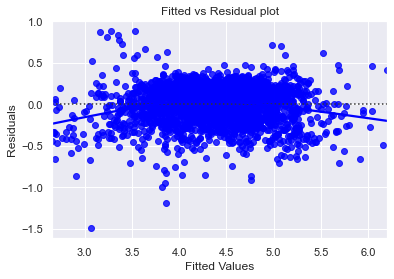

In [43]:
#plotting the fitted values vs residuals
sns.residplot(data = df_pred, x="Fitted Values", y="Residuals", color="blue", lowess=True)

plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted vs Residual plot")
plt.show()

- The scatter plot shows no pattern among the points when plotted by residuals (errors) vs fitted values (predicted values). 
- This means that the model is not capturing any non-linear effects. 
- Since the scatter plot shows no pattern, we can consider the assumptions of linearity and independence satisfied. 

### 4. Testing for Normality
- We will do this by plotting the residuals using a histogram and utilizing a QQ plot.
- We will also double check for normality using a Shapiro-Wilk test.  

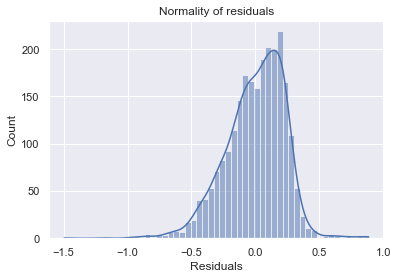

In [44]:
sns.histplot(data=df_pred, x="Residuals", kde=True)
plt.title("Normality of residuals")
plt.show()

- The histogram of residuals has a bell-shape for the most part. The shape is very slightly skewed to the left but is mostly symmetrical. 
- We will further confirm normality with a QQ plot

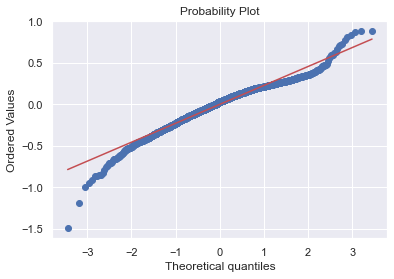

In [45]:
#creating a QQ plot of the residuals
stats.probplot(df_pred["Residuals"], dist="norm", plot=pylab)
plt.show()

In [46]:
df_pred["Residuals"].skew()

-0.6266423573313972

- The residuals follow a straight line more or less, except for the tails. 
- The skewness value (-0.627) shows that the data is moderately skewed. But since this value is not greater than -1, we can consider this amount of skewness acceptable for the model. 
- This seems pretty normal but we will double check using a Shapiro-Wilk test. 

In [47]:
#Running a Shapiro-Wilk test
stats.shapiro(df_pred["Residuals"])

ShapiroResult(statistic=0.9690815806388855, pvalue=2.105690889523832e-22)

For the Shapiro-Wilk test, we will be testing the following hypotheses:  
    - Null hypothesis: residuals are normally distributed
    - Alt hypothesis: residuals are not normally distributed
- Since the p-value is less than 0.05, we can reject the null hypothesis of normally distributed residuals. 
- The residuals are technically not normal according to the test but as an approximation, we can accept this as is. 


The distribution is close enough to normality to deem the assumption as satisfied. 

### 5. Testing for Homoscedasticity

To test for homoscedasticity (lack of heteroscedasticity) using a Goldfeldquandt test. 

- For the test, we will be using the following hypotheses: 
    - Null hypothesis: residuals are homoscedastic
    - Alt hypothesis: residuals have heteroscedasticity

In [48]:
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(df_pred["Residuals"], x_train2)
lzip(name, test)

[('F statistic', 1.0431128107825935), ('p-value', 0.23292738306794344)]

- Since the p-value is greater than 0.05, we fail to reject the null hypothesis. Therefore, the residuals are homoscedastic. 
- The assumption of homoscedasticity is therefore satisfied. 

## Final Model Summary

Now that all of the assumptions of linear regression are checked and satisfied, we can will create a final regression model summary using olsmod2, x_train2, x_test2, y_train, and y_test. 

In [49]:
#predictions on the test set
pred = olsmod2.predict(x_test2)

#creating a new dataframe with the actual and predicted values
df_pred_test = pd.DataFrame({"Actual": y_test, "Predicted": pred})
df_pred_test.sample(10, random_state=1)

,Actual,Predicted
1995,4.566741,4.373852
2341,3.696103,3.962951
1913,3.592093,3.691084
688,4.306495,4.116870
650,4.522115,5.137584
2291,4.259294,4.395320
40,4.997685,5.434438
1884,3.875359,4.054813
2538,4.206631,4.047358
45,5.380450,5.276783


- Using our model, the actual and predicted values are very similar and comparable. This means that we have created an effective and reliable model. 
- A bargraph will be produced to show visualize the comparison between the actual and predicted values. Because the number of records is so large, we will only be taking a sample of 25 records to use within the bargraph. 

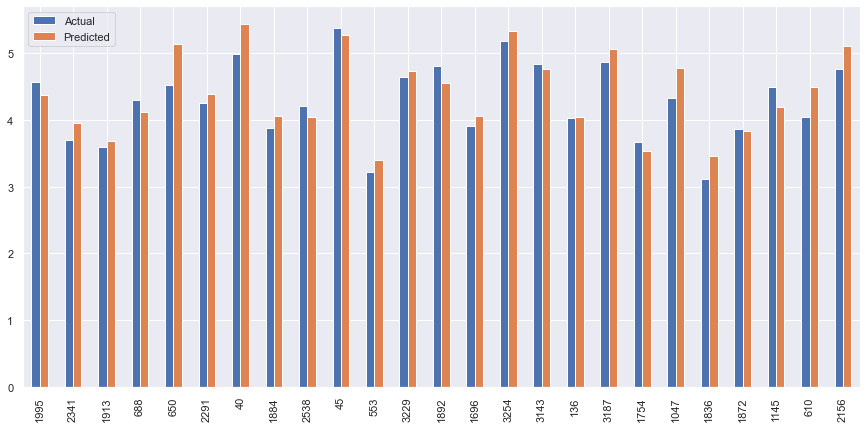

In [50]:
df2 = df_pred_test.sample(25, random_state=1)
df2.plot(kind = "bar", figsize = (15,7))
plt.show()

In [51]:
# Checking the model performance on the train set (70% of the data)
print("Training Performance\n")
ols_final_train = model_performance_regression(olsmod2, x_train2, y_train)
ols_final_train

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,25.586068,16.732904,0.787221,0.785892,19.037828


In [52]:
# Checking the model performance on the test set (30% of the data)
print("Test Performance\n")
ols_final_test = model_performance_regression(olsmod2, x_test2, y_test)
ols_final_test

Test Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,24.089251,16.476979,0.792189,0.789136,19.265007


- The model is able to explain 78% of the variation in the data. 
- The train and test RMSE and MAE are close in value, indicating that our model is not overfit. 
- The MAPE suggests that we can predict within 19% of the used price. 
- Our model is a good tool for prediction and inference. 

In [53]:
#recreating the final statsmodel model and summary
olsmodel_final = sm.OLS(y_train, x_train2).fit()
print(olsmodel_final.summary())

                            OLS Regression Results                            
Dep. Variable:         used_price_log   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     988.3
Date:                Tue, 06 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:02:08   Log-Likelihood:                 104.95
No. Observations:                2417   AIC:                            -181.9
Df Residuals:                    2403   BIC:                            -100.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -19.4495      3.64

## Actionable Insights and Recommendations

Significance of predictors and key takeaways:
- Most of the predictor variables have positive coefficients. This means that as these variables increase, the used price of the device also increases. For example, for every 1 unit increase in screen size (1 cm), the value of the device when being sold used increases by 0.025 euros. 
- Newer devices (increased release year) increases the value of the device when sold. 
- As screen size, main camera megapixels, selfie camera megapixels, internal ram, weight, and release year increase, the value of the device when being sold used also increases. 
- Battery life has a negative coefficient value (but the coefficient value is very small). This means that as the overall battery life in mAhs increases, the price when sold used tends to decrease every so slightly. Because of this, we can essentially assume that increased battery capacity should not be a selling point for used devices as it really does not increase the value at all. 
- Devices made by Lenovo, Nokia, and Xiaomi actually have a positive influence on the used price compared to all of the other the brands that were dropped while building the model. From a sales standpoint, these 3 brands have a slight influence on the resale value of the used device. 
- Os_Others also has a negative coefficient. This means that essentially if devices do not have a Android, iOS, or Windows operating system, this brings down the price of the device when sold used. Devices that have a more well-known OS have better resale value. 
- new_price_log has the highest coefficient value than any other variable. This means that for every 1 unit (1 euro) increase in the price of the device when it is brand new, the used price increases by 0.42 euros. This makes sense given the nature of selling anything used - the more expensive the object was to buy originally, the higher value it holds, and the more expensive it was still be when sold used. 
    - From a business standpoint, devices that are more expensive when new are going to be more valuable when sold used. 
    - The new price of the device has the biggest influence on the price when sold used compared to any other trait. 